In [2]:
##load NLST data set with train and tune split
import pandas as pd
import numpy as np

# we use train for trainining, and tune for validation
tune_path = 'nlst_tune_with_labels.npz' 
train_path = 'nlst_train_with_labels.npz' 

def read_embeddings(f):
    data = np.load(f,allow_pickle=True)
    key = data.files[0]
    return pd.DataFrame.from_dict(data[key].item(), orient='index')

df_tune = read_embeddings(tune_path)
df_train = read_embeddings(train_path)

demo=pd.read_csv('nlst_780_prsn_idc_20210527.csv')

def get_pid(df):
    pid=[int(i.split('/')[1]) for i in df.index]
    df['pid']=pid
    return df
df_tune=get_pid(df_tune)
df_train=get_pid(df_train)


def add_demo(df):
    columns=['age','gender','race']
    pid=list(df['pid'])
    demo_pid=list(demo['pid'])
    indices = [demo_pid.index(x) for x in pid if x in demo_pid]
    #print(indices)
    selected_rows = demo.iloc[indices]
    #print(selected_rows)
    selected_columns = selected_rows[columns]
    selected_columns.reset_index(drop=True, inplace=True)
    print(len(selected_columns),len(df))
    df['age']=list(selected_columns['age'])
    df['gender']=list(selected_columns['gender'])
    df['race']=list(selected_columns['race'])

    return df

df_tune=add_demo(df_tune)
df_train=add_demo(df_train)

C:\Users\19236\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\19236\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


11421 11421
52696 52696


In [3]:
## Put sex and age into dataloader
import torch
from torch.utils.data import DataLoader, TensorDataset
    
batch_size = 32
num_epochs = 100
lambda_adv = 0.1  # Trade-off hyperparameter
n=100


X=np.array(list(df_train['embedding']))[:n]
y_sex=np.array(list(df_train['gender']))[:n]-1
y_age=np.array(list(df_train['age']))[:n]

def get_dataloader(X):
    X = torch.Tensor(X)
    y=np.vstack((y_sex,y_age)).T
    sensitive_attr = torch.Tensor(y) # Sensitive attribute
    dataset = TensorDataset(X, sensitive_attr)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader
dataloader=get_dataloader(X)

In [4]:
##define model and set training loop
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
# Reparameterization trick
def reparameterize(mean, log_var):
    std = torch.exp(0.5*log_var)
    epsilon = torch.randn_like(std)
    return mean + epsilon*std

def train(num_epochs=10,dataloader=dataloader,latent_dim=100,num_sensitives=2):
    # Encoder
    class Encoder(nn.Module):
        def __init__(self, input_dim, latent_dim):
            super(Encoder, self).__init__()
            self.fc = nn.Linear(input_dim, 2 * latent_dim)  # Mean and log-variance

        def forward(self, x):
            params = self.fc(x)
            mean, log_var = torch.chunk(params, 2, dim=-1)
            return mean, log_var

    # Decoder
    class Decoder(nn.Module):
        def __init__(self, latent_dim, output_dim):
            super(Decoder, self).__init__()
            self.fc = nn.Linear(latent_dim, output_dim)

        def forward(self, z):
            return self.fc(z)

    class MixedAdversary(nn.Module):
        def __init__(self, latent_dim, attribute_types):
            super(MixedAdversary, self).__init__()
            self.branches = nn.ModuleList()
            for attr_type in attribute_types:
                if attr_type == "binary":
                    self.branches.append(nn.Linear(latent_dim, 1))  # Binary output
                elif attr_type == "regression":  # Multiclass with 'attr_type' classes
                    self.branches.append(nn.Linear(latent_dim, 1))  # regression output

        def forward(self, z):
            outputs = []
            for branch in self.branches:
                outputs.append(branch(z))
            return outputs
    
    # Loss function for VAE with fairness constraint
    def vae_loss(recon_x, x, mean, log_var):
        recon_loss = nn.MSELoss()(recon_x, x)
        kl_div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        return recon_loss + kl_div

    # Training Loop
    encoder = Encoder(input_dim=1408, latent_dim=latent_dim)
    decoder = Decoder(latent_dim=latent_dim, output_dim=1408)
    attribute_types=['binary',20]
    mixed_adversary = MixedAdversary(latent_dim=latent_dim, attribute_types=['binary','regression'])

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.0005)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.0005)
    adv_optimizer = optim.Adam(mixed_adversary.parameters(), lr=0.002)

    for epoch in range(num_epochs):
        for X_batch, sensitive_batch in dataloader:
            # Encoder forward pass
            mean, log_var = encoder(X_batch)
            z = reparameterize(mean, log_var)

            # Decoder forward pass
            recon_batch = decoder(z)

            # Compute VAE loss
            vae_loss_value = vae_loss(recon_batch, X_batch, mean, log_var)

            # Train adversary (predict sensitive attributes from z)
            
            adv_preds = mixed_adversary(z.detach())  # Detach z to avoid backprop through adversary

            # Compute adversary loss
            adv_loss = 0
            for i, pred in enumerate(adv_preds):
                #print(pred.shape,sensitive_batch[:,i].shape)
                if attribute_types[i] == "binary":
                    adv_loss += nn.BCELoss()(torch.sigmoid(pred), torch.unsqueeze(sensitive_batch[:,i],1))
                else:  
                    adv_loss += nn.MSELoss()(pred, torch.unsqueeze(sensitive_batch[:,i],1))
            #print('--------')
            encoder_loss = -adv_loss  # Maximize adversary's loss

            # Backpropagate
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            adv_optimizer.zero_grad()

            vae_loss_value.backward(retain_graph=True)
            encoder_loss.backward()

            encoder_optimizer.step()
            decoder_optimizer.step()
            adv_optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, VAE Loss: {vae_loss_value.item():.4f}, Adv Loss: {adv_loss.item():.4f}")
            
    return encoder,decoder


In [5]:
## train model
encoder,decoder=train(num_epochs=100,dataloader=dataloader,latent_dim=500)

Epoch 0, VAE Loss: 104.3439, Adv Loss: 3588.1770
Epoch 10, VAE Loss: 6.0480, Adv Loss: 3172.3447
Epoch 20, VAE Loss: 3.1283, Adv Loss: 3421.0164
Epoch 30, VAE Loss: 2.2524, Adv Loss: 3290.5630
Epoch 40, VAE Loss: 2.9315, Adv Loss: 4533.5186
Epoch 50, VAE Loss: 1.9562, Adv Loss: 3549.3247
Epoch 60, VAE Loss: 2.1175, Adv Loss: 4287.3447
Epoch 70, VAE Loss: 1.8475, Adv Loss: 3466.8044
Epoch 80, VAE Loss: 1.6293, Adv Loss: 3596.4871
Epoch 90, VAE Loss: 1.5425, Adv Loss: 3538.3433


In [6]:
## methods for evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
# Reparameterization trick
def reparameterize(mean, log_var):
    std = torch.exp(0.5*log_var)
    epsilon = torch.randn_like(std)
    return mean + epsilon*std

def get_classification_res(original_X, recon_X, i):
    clf1 = LogisticRegression(random_state=0,max_iter=1000).fit(original_X, i)
    one=clf1.score(original_X,i)
    
    clf1 = LogisticRegression(random_state=0,max_iter=1000).fit(recon_X, i)
    two=clf1.score(recon_X,i)
    return np.round(one,3),np.round(two,3)

def get_regression_res(original_X, recon_X, i):
    clf1 = LinearRegression().fit(original_X, i)
    y_pred=clf1.predict(original_X)
    mae1=mean_absolute_error(i,y_pred)
    
    clf1 = LinearRegression().fit(recon_X, i)
    y_pred=clf1.predict(recon_X)
    mae2=mean_absolute_error(i,y_pred)
    return np.round(mae1,3),np.round(mae2,3)


def evaluate(original_X, recon_X, sensitive_label,label):
    attr=['binary','regression']
    sl=[]
    for index,i in enumerate(sensitive_label):
        if attr[index]=='binary':
            one,two=get_classification_res(original_X, recon_X, i)
            if two<one:
                sl.append(['good',one,two])
            else:
                sl.append(['bad',one,two])
        elif attr[index]=='regression':
            one,two=get_regression_res(original_X, recon_X, i)
            if two>one:
                sl.append(['good',one,two])
            else:
                sl.append(['bad',one,two])

    print(sl)
    l=[]
    for i in label:
        one,two=get_classification_res(original_X, recon_X, i)
        l.append([one,two])
    print(l)

In [7]:
from sklearn.metrics import roc_auc_score,accuracy_score
X_test=np.array(list(df_tune['embedding']))
y_test=np.array(list(df_tune['gender']))-1
y_test_age=np.array(list(df_tune['age']))

# Testing the VAE Output
encoder.eval()
decoder.eval()
#mixed_adversary.eval()
test_data = torch.Tensor(X_test)
with torch.no_grad():
    # Test on some data
    mean, log_var = encoder(test_data)
    z = reparameterize(mean, log_var)
    
    # Reconstructed data
    recon_test_data = decoder(z)

y_test_1=np.array(list(df_tune['cancer_in_1']))
y_test_2=np.array(list(df_tune['cancer_in_2']))

evaluate(X_test, recon_test_data, [y_test,y_test_age],[y_test_1,y_test_2])

[['good', 0.994, 0.648], ['good', 2.734, 4.117]]
[[0.986, 0.986], [0.977, 0.977]]


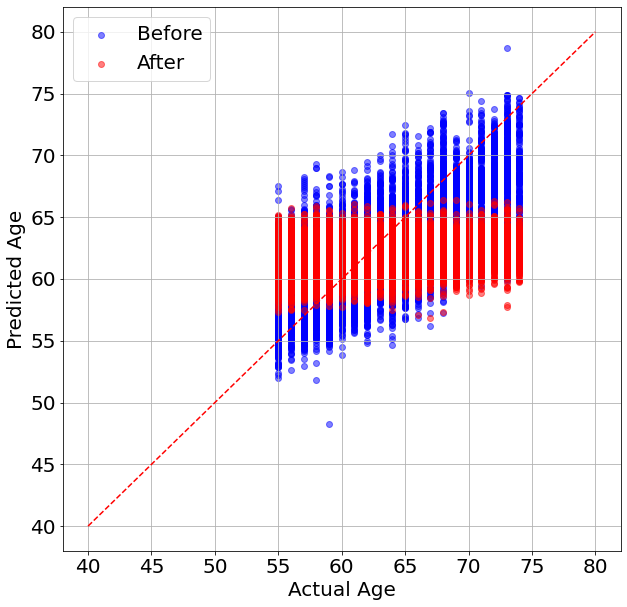

In [11]:
import matplotlib.pyplot as plt

#age before and after
original_X=X_test
recon_X=recon_test_data
i=y_test_age
clf1 = LinearRegression().fit(original_X, i)
pred1=clf1.predict(original_X)
    
clf1 = LinearRegression().fit(recon_X, i)
pred2=clf1.predict(recon_X)

plt.rcParams['font.size'] = 20  # Set default font size

plt.figure(figsize=(10, 10))
plt.scatter(i, pred1, alpha=0.5, label='Before', color='b')
plt.scatter(i, pred2, alpha=0.5, label='After', color='r')

plt.plot([40, 80], [40, 80], 'r--')  # Reference line
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.legend()

plt.grid(True)
plt.savefig('age_scatter_before_and_after.png', dpi=300,bbox_inches='tight')

Accuracy for class 0: 1.00
Accuracy for class 1: 0.00


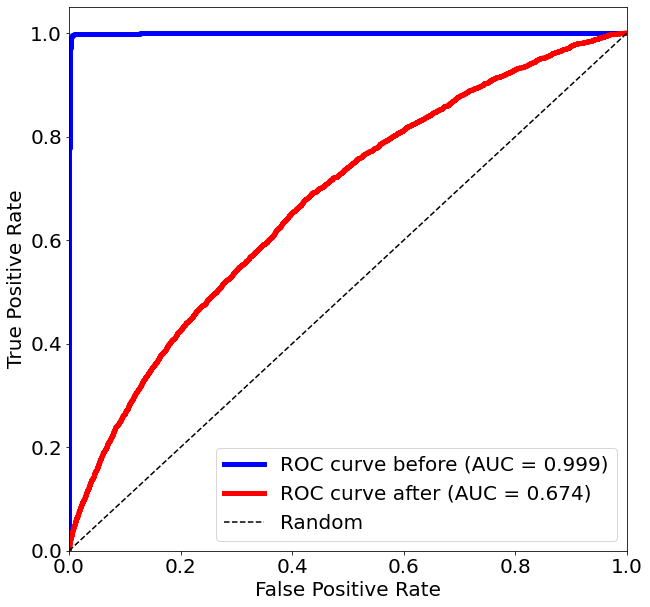

In [12]:
from sklearn.metrics import roc_auc_score,accuracy_score,roc_curve,auc

#sex before and after
original_X=X_test
recon_X=recon_test_data
i=y_test
clf1 = LogisticRegression(random_state=0,max_iter=1000).fit(original_X, i)
pred1=clf1.predict_proba(original_X)[:, 1]
y_pred1=clf1.predict(original_X)

clf1 = LogisticRegression(random_state=0,max_iter=1000).fit(recon_X, i)
pred2=clf1.predict_proba(recon_X)[:, 1]
y_pred2=clf1.predict(original_X)

plt.rcParams['font.size'] = 20  # Set default font size

# Calculate ROC curve
fpr1, tpr1, thresholds = roc_curve(i, pred1) 
roc_auc1 = auc(fpr1, tpr1)
fpr2, tpr2, thresholds = roc_curve(i, pred2) 
roc_auc2 = auc(fpr2, tpr2)
from sklearn.metrics import roc_auc_score,classification_report,confusion_matrix
conf_matrix = confusion_matrix(i, y_pred2)
# Per-class accuracy
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Display results
for i, acc in enumerate(per_class_accuracy):
    print(f"Accuracy for class {i}: {acc:.2f}")


# Plot the ROC curve
plt.figure(figsize=(10, 10))
plt.plot(fpr1, tpr1, label='ROC curve before (AUC = %0.3f)' % roc_auc1,linewidth=5.0,color="blue")
plt.plot(fpr2, tpr2, label='ROC curve after (AUC = %0.3f)' % roc_auc2,linewidth=5.0,color="red")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('sex_roc_before_and_after.png', dpi=300,bbox_inches='tight')


[0 1]
0.8574588001049066 0.8926469092719167


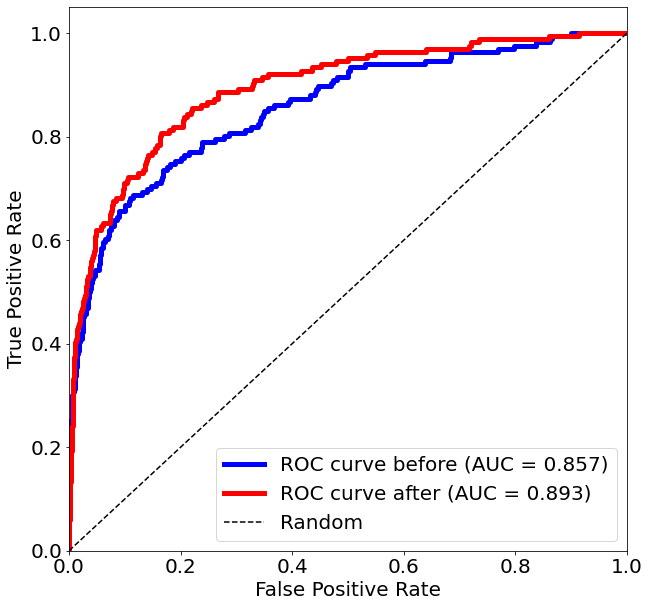

In [13]:
#c1 before and after
original_X=X_test
recon_X=recon_test_data
i=y_test_1
print(np.unique(i))
clf1 = LogisticRegression(random_state=0,max_iter=1000).fit(original_X, i)
#print(clf1.score(original_X,i))
pred1=clf1.predict_proba(original_X)[:, 1]
    
clf1 = LogisticRegression(random_state=0,max_iter=1000).fit(recon_X, i)
#print(clf1.score(recon_X,i))
pred2=clf1.predict_proba(recon_X)[:, 1]
   
plt.rcParams['font.size'] = 20  # Set default font size

# Calculate ROC curve
fpr1, tpr1, thresholds = roc_curve(i, pred1) 
roc_auc1 = auc(fpr1, tpr1)
fpr2, tpr2, thresholds = roc_curve(i, pred2)
roc_auc2 = auc(fpr2, tpr2)
print(roc_auc1,roc_auc2)
# Plot the ROC curve
plt.figure(figsize=(10, 10))
plt.plot(fpr1, tpr1, label='ROC curve before (AUC = %0.3f)' % roc_auc1,linewidth=5.0,color="blue")
plt.plot(fpr2, tpr2, label='ROC curve after (AUC = %0.3f)' % roc_auc2,linewidth=5.0,color="red")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('cancer_in_1_roc_before_and_after.png', dpi=300,bbox_inches='tight')

[0 1]
0.8566003556247389 0.8420918476879279


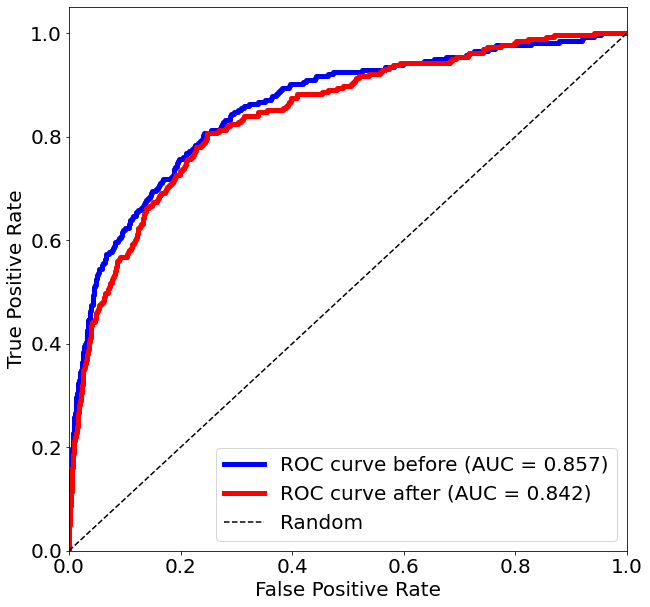

In [14]:
#c2 before and after
original_X=X_test
recon_X=recon_test_data
i=y_test_2
print(np.unique(i))
clf1 = LogisticRegression(random_state=0,max_iter=1000).fit(original_X, i)
#print(clf1.score(original_X,i))
pred1=clf1.predict_proba(original_X)[:, 1]
    
clf1 = LogisticRegression(random_state=0,max_iter=1000).fit(recon_X, i)
#print(clf1.score(recon_X,i))
pred2=clf1.predict_proba(recon_X)[:, 1]
   
plt.rcParams['font.size'] = 20  # Set default font size

# Calculate ROC curve
fpr1, tpr1, thresholds = roc_curve(i, pred1) 
roc_auc1 = auc(fpr1, tpr1)
fpr2, tpr2, thresholds = roc_curve(i, pred2) 
roc_auc2 = auc(fpr2, tpr2)
print(roc_auc1,roc_auc2)

# Plot the ROC curve
plt.figure(figsize=(10, 10))
plt.plot(fpr1, tpr1, label='ROC curve before (AUC = %0.3f)' % roc_auc1,linewidth=5.0,color="blue")
plt.plot(fpr2, tpr2, label='ROC curve after (AUC = %0.3f)' % roc_auc2,linewidth=5.0,color="red")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('cancer_in_2_roc_before_and_after.png', dpi=300,bbox_inches='tight')

## Additional Experiment: Equal Opportunity Difference

In [16]:
#c1 before and after
original_X=X_test
recon_X=recon_test_data
i=y_test_1
sex=y_test
print(np.unique(i))
clf1 = LogisticRegression(random_state=0,max_iter=1000).fit(original_X, i)
#print(clf1.score(original_X,i))
pred1=clf1.predict_proba(original_X)[:, 1]
y_pred1=clf1.predict(original_X)
  
clf1 = LogisticRegression(random_state=0,max_iter=1000).fit(recon_X, i)
#print(clf1.score(recon_X,i))
pred2=clf1.predict_proba(recon_X)[:, 1]
y_pred2=clf1.predict(recon_X)
        
print('--------')
    
from fairlearn.metrics import equal_opportunity_difference,equal_opportunity_ratio

print('sex before',equal_opportunity_difference(i,
                                y_pred1,
                                sensitive_features=sex))
print('sex after',equal_opportunity_difference(i,
                                y_pred2,
                                sensitive_features=sex))
print('--------')

print('age before',equal_opportunity_difference(i,
                                y_pred1,
                                sensitive_features=y_test_age))
print('age after',equal_opportunity_difference(i,
                                y_pred2,
                                sensitive_features=y_test_age))


[0 1]
--------
sex before 0.03498888065233506
sex after 0.0035581912527798375
--------
age before 0.3333333333333333
age after 0.1111111111111111


In [20]:
#c2 before and after
original_X=X_test
recon_X=recon_test_data
i=y_test_2
sex=y_test
print(np.unique(i))
clf1 = LogisticRegression(random_state=0,max_iter=1000).fit(original_X, i)
#print(clf1.score(original_X,i))
pred1=clf1.predict_proba(original_X)[:, 1]
y_pred1=clf1.predict(original_X)
  
clf1 = LogisticRegression(random_state=0,max_iter=1000).fit(recon_X, i)
#print(clf1.score(recon_X,i))
pred2=clf1.predict_proba(recon_X)[:, 1]
y_pred2=clf1.predict(recon_X)
        
print('--------')
    
from fairlearn.metrics import equal_opportunity_difference,equal_opportunity_ratio

print('sex before',equal_opportunity_difference(i,
                                y_pred1,
                                sensitive_features=sex))
print('sex after',equal_opportunity_difference(i,
                                y_pred2,
                                sensitive_features=sex))
print('--------')

print('age before',equal_opportunity_difference(i,
                                y_pred1,
                                sensitive_features=y_test_age))
print('age after',equal_opportunity_difference(i,
                                y_pred2,
                                sensitive_features=y_test_age))


[0 1]
--------
sex before 0.0005391804457225043
sex after 0.0005391804457225043
--------
age before 0.2
age after 0.16666666666666666


## Additioanl Experiment: Data Poisoning

In [21]:
# Define flipping percentages, male
flipping_percentages = [0, 25, 50, 75, 100]
original_X=X_test
recon_X=recon_test_data
sex=y_test
i=y_test_1
import copy

# Function to flip labels
def flip_labels(y, indices, flip_percentage):
    n = len(indices)
    n_to_flip = int(n * flip_percentage / 100)  # Number of labels to flip
    flip_indices = np.random.choice(indices, size=n_to_flip, replace=False)  # Randomly select indices
    flipped_y = copy.deepcopy(y)
    flipped_y[flip_indices] = 1 - flipped_y[flip_indices]  # Flip labels (0 <-> 1)
    return flipped_y, flip_indices

# Get male indices
male_indices = np.where(sex == 0)[0]
female_indices = np.where(sex == 1)[0]


# Perform flipping for each percentage
for percentage in flipping_percentages:
    flipped_y, flipped_indices = flip_labels(i, male_indices, percentage)
    print(flipped_y.shape,i.shape)
    
    clf1 = LogisticRegression(random_state=0,max_iter=1000).fit(original_X, flipped_y)
    pred1=clf1.predict_proba(original_X)[:, 1]
    y_pred1=clf1.predict(original_X)

    clf1 = LogisticRegression(random_state=0,max_iter=1000).fit(recon_X, flipped_y)
    pred2=clf1.predict_proba(recon_X)[:, 1]
    y_pred2=clf1.predict(recon_X)

    #print(roc_auc_score(i, pred1),roc_auc_score(i, pred2))
    from fairlearn.metrics import equal_opportunity_difference,equal_opportunity_ratio

    print(equal_opportunity_difference(i,
                                    y_pred1,
                                    sensitive_features=sex))
    print(equal_opportunity_difference(i,
                                    y_pred2,
                                    sensitive_features=sex))
    print('------')

(11421,) (11421,)
0.03498888065233506
0.0035581912527798375
------
(11421,) (11421,)
0.021052631578947368
0.0069681245366938465
------
(11421,) (11421,)
0.6
0.0034099332839140108
------
(11421,) (11421,)
0.9894736842105263
0.10659747961452926
------
(11421,) (11421,)
0.9613046701260193
0.014974054855448449
------


In [22]:
# Define flipping percentages, female
flipping_percentages = [0, 25, 50, 75, 100]
original_X=X_test
recon_X=recon_test_data
sex=y_test
i=y_test_1
import copy

# Function to flip labels
def flip_labels(y, indices, flip_percentage):
    n = len(indices)
    n_to_flip = int(n * flip_percentage / 100)  # Number of labels to flip
    flip_indices = np.random.choice(indices, size=n_to_flip, replace=False)  # Randomly select indices
    flipped_y = copy.deepcopy(y)
    flipped_y[flip_indices] = 1 - flipped_y[flip_indices]  # Flip labels (0 <-> 1)
    return flipped_y, flip_indices

# Get male indices
male_indices = np.where(sex == 0)[0]
female_indices = np.where(sex == 1)[0]


# Perform flipping for each percentage
for percentage in flipping_percentages:
    flipped_y, flipped_indices = flip_labels(i, female_indices, percentage)
    print(flipped_y.shape,i.shape)
    
    clf1 = LogisticRegression(random_state=0,max_iter=1000).fit(original_X, flipped_y)
    pred1=clf1.predict_proba(original_X)[:, 1]
    y_pred1=clf1.predict(original_X)

    clf1 = LogisticRegression(random_state=0,max_iter=1000).fit(recon_X, flipped_y)
    pred2=clf1.predict_proba(recon_X)[:, 1]
    y_pred2=clf1.predict(recon_X)

    #print(roc_auc_score(i, pred1),roc_auc_score(i, pred2))
    from fairlearn.metrics import equal_opportunity_difference,equal_opportunity_ratio

    print(equal_opportunity_difference(i,
                                    y_pred1,
                                    sensitive_features=sex))
    print(equal_opportunity_difference(i,
                                    y_pred2,
                                    sensitive_features=sex))
    print('------')

(11421,) (11421,)
0.03498888065233506
0.0035581912527798375
------
(11421,) (11421,)
0.15492957746478872
0.0
------
(11421,) (11421,)
0.6197183098591549
0.010526315789473684
------
(11421,) (11421,)
0.9154929577464789
0.0032616753150481737
------
(11421,) (11421,)
0.9613046701260193
0.014974054855448449
------


## cancer in 2 years

In [23]:
# Define flipping percentages, male
flipping_percentages = [0, 25, 50, 75, 100]
original_X=X_test
recon_X=recon_test_data
sex=y_test
i=y_test_2
import copy

# Function to flip labels
def flip_labels(y, indices, flip_percentage):
    n = len(indices)
    n_to_flip = int(n * flip_percentage / 100)  # Number of labels to flip
    flip_indices = np.random.choice(indices, size=n_to_flip, replace=False)  # Randomly select indices
    flipped_y = copy.deepcopy(y)
    flipped_y[flip_indices] = 1 - flipped_y[flip_indices]  # Flip labels (0 <-> 1)
    return flipped_y, flip_indices

# Get male indices
male_indices = np.where(sex == 0)[0]
female_indices = np.where(sex == 1)[0]


# Perform flipping for each percentage
for percentage in flipping_percentages:
    flipped_y, flipped_indices = flip_labels(i, male_indices, percentage)
    print(flipped_y.shape,i.shape)
    
    clf1 = LogisticRegression(random_state=0,max_iter=1000).fit(original_X, flipped_y)
    pred1=clf1.predict_proba(original_X)[:, 1]
    y_pred1=clf1.predict(original_X)

    clf1 = LogisticRegression(random_state=0,max_iter=1000).fit(recon_X, flipped_y)
    pred2=clf1.predict_proba(recon_X)[:, 1]
    y_pred2=clf1.predict(recon_X)

    from fairlearn.metrics import equal_opportunity_difference,equal_opportunity_ratio

    print(equal_opportunity_difference(i,
                                    y_pred1,
                                    sensitive_features=sex))
    print(equal_opportunity_difference(i,
                                    y_pred2,
                                    sensitive_features=sex))
    print('------')

(11421,) (11421,)
0.0005391804457225043
0.0005391804457225043
------
(11421,) (11421,)
0.00641025641025641
0.009345794392523364
------
(11421,) (11421,)
0.5705128205128205
0.039779535106637905
------
(11421,) (11421,)
0.9871794871794872
0.09711238916846393
------
(11421,) (11421,)
0.9935897435897436
0.018092499400910622
------


In [24]:
# Define flipping percentages, female
flipping_percentages = [0, 25, 50, 75, 100]
original_X=X_test
recon_X=recon_test_data
sex=y_test
i=y_test_2
import copy

# Function to flip labels
def flip_labels(y, indices, flip_percentage):
    n = len(indices)
    n_to_flip = int(n * flip_percentage / 100)  # Number of labels to flip
    flip_indices = np.random.choice(indices, size=n_to_flip, replace=False)  # Randomly select indices
    flipped_y = copy.deepcopy(y)
    flipped_y[flip_indices] = 1 - flipped_y[flip_indices]  # Flip labels (0 <-> 1)
    return flipped_y, flip_indices

# Get male indices
male_indices = np.where(sex == 0)[0]
female_indices = np.where(sex == 1)[0]


# Perform flipping for each percentage
for percentage in flipping_percentages:
    flipped_y, flipped_indices = flip_labels(i, female_indices, percentage)
    print(flipped_y.shape,i.shape)
    
    clf1 = LogisticRegression(random_state=0,max_iter=1000).fit(original_X, flipped_y)
    pred1=clf1.predict_proba(original_X)[:, 1]
    y_pred1=clf1.predict(original_X)

    clf1 = LogisticRegression(random_state=0,max_iter=1000).fit(recon_X, flipped_y)
    pred2=clf1.predict_proba(recon_X)[:, 1]
    y_pred2=clf1.predict(recon_X)


    from fairlearn.metrics import equal_opportunity_difference,equal_opportunity_ratio

    print(equal_opportunity_difference(i,
                                    y_pred1,
                                    sensitive_features=sex))
    print(equal_opportunity_difference(i,
                                    y_pred2,
                                    sensitive_features=sex))
    print('------')

(11421,) (11421,)
0.0005391804457225043
0.0005391804457225043
------
(11421,) (11421,)
0.17757009345794392
0.0029355379822669538
------
(11421,) (11421,)
0.48598130841121495
0.019769949676491736
------
(11421,) (11421,)
0.8691588785046729
0.0651809249940091
------
(11421,) (11421,)
0.9935897435897436
0.018092499400910594
------


## TSNE Visualization

In [125]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=100).fit_transform(recon_test_data)

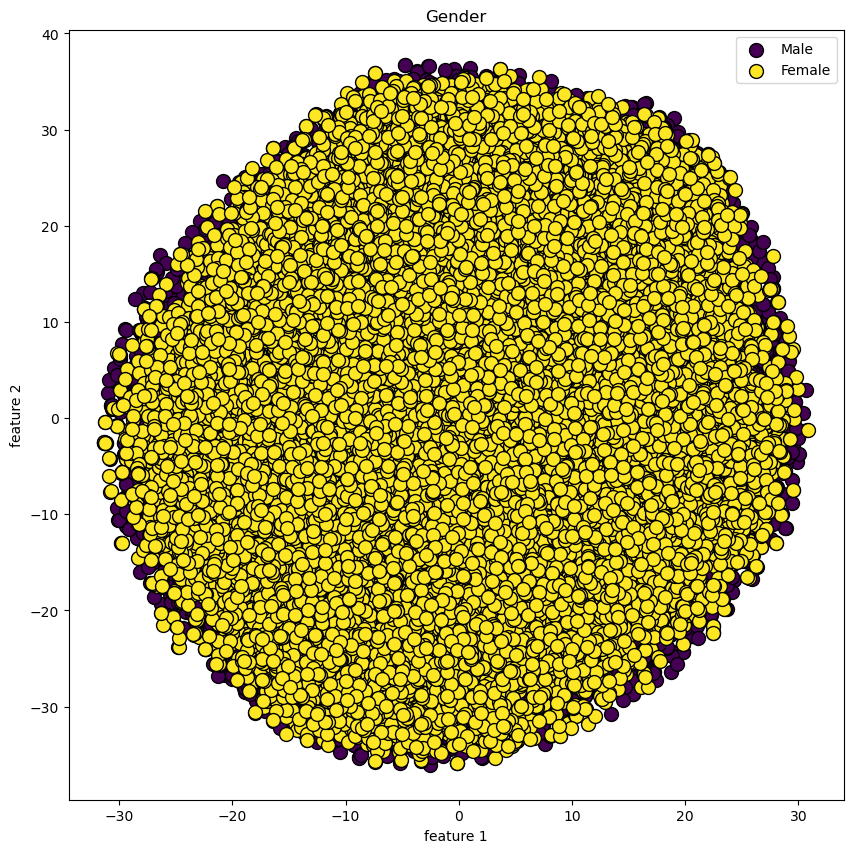

In [126]:
import matplotlib.pyplot as plt
y_train=np.array(list(df_train['gender']))-1

x=X_embedded[:,0]
y=X_embedded[:,1]
labels=y_test
# Create a figure and axis
plt.figure(figsize=(10, 10))

# Create a scatter plot for each label category
unique_labels = np.unique(labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))  # Generate colors

for label, color in zip(unique_labels, colors):
    if label==0:
        t='Male'
    else:
        t='Female'
    plt.scatter(x[labels == label], y[labels == label], color=color, label=t, edgecolor='k', s=100)


# Add titles and labels
plt.title('Gender')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()

# Show plot
plt.savefig('gender.png', dpi=300,bbox_inches='tight')
plt.show()
